---
title: keras教程-n-循环神经网络的注意力机制的理论和实现
date: 2018-09-02 20:17:55
tags: [keras教程]
toc: true
xiongzhang: false

---
<span></span>
<!-- more -->


本文代码运行环境:

- windows10
- python3.6
- jupyter notebook
- tensorflow 1.x
- keras 2.x

### 案例介绍

让我们考虑这样一种情景: 一个序列v(假如维度是10), 里面都是数字, 我们想要预测`abs(v[1:4]-v[5:8])=?`, 也就是序列中, 只有6位数是有效的, 其他的数字都是随机数, 我们想要求这6位数分成的两个三位数的差的绝对值是多少。那么我们可以使用注意力机制, 它可以有效的忽略随机数的干扰, 从而提取得到有效的信息。

### 理论知识

#### 背景知识

在一次采访中，现在是OpenAI研究主任的Ilya Sutskever提到，注意机制是最激动人心的进步之一，他们将在这个方向上继续研究。听起来让人兴奋不已。但是什么是注意机制？

神经网络中的注意机制基于人类中发现的视觉注意机制。人类视觉注意力得到充分研究，虽然存在不同的模型，但它们都基本上都认为, 注意力能够以“高分辨率”聚焦于图像的某个区域，同时以“低分辨率”感知周围图像，然后随着时间的推移调整焦点。

神经网络中的注意力机制历史悠久，特别是在图像识别方面。但是直到2016年才将注意力机制引入NLP（并且越来越多地用于视觉）的循环神经网络架构中。这就是我们将在这篇文章中关注的内容。

#### 注意力机制

要理解注意力机制需要具备循环神经网络的基础知识, 可以参考我这篇文章: [keras教程-n-10分钟入门LSTM](#), 下面我们用一个机器翻译的例子来做说明。

<img src="images/rnn-translate.png" />

上面的流程图就是一个循环神经网络的seq2seq模型, 实现的功能就是把"Echt dicke Kiste"翻译成"Awesome sauce", 如果你仔细观察就会发现, 这个模型的解码器(蓝色部分)只利用了编码器最后一次循环的状态。也就是说, 想要翻译句子, 必须把所有的信息都保存到一个状态向量里, 这对循环神经网络是有难度的, 尤其当句子很长的时候, 难度更大。

解决上面的问题的方法就是使用注意机制。通过注意机制，我们不再尝试将完整的句子编码为固定长度的向量。相反，我们允许解码器在生成的每个步骤“参考”源句子的不同部分。重要的是，我们让模型根据输入句子以及它到目前为止产生的内容来学习要注意的内容。因此，在非常类似的语言（如英语和德语）中，解码器可能会选择按顺序处理事物。在翻译第一个英文单词时注意第一个单词，依此类推。如下所示：

<img src="images/rnn-attention.png" />

上图中编码器使用了双向循环神经网络, 但这不是重点, 你可以忽略。 $y_t$代表输出的字符, $x_T$代表输入的字符, $a_t,T$代表权重。重要的是，每个解码器输出字$y_t$现在取决于所有输入状态的加权组合，而不仅仅是最后状态。a是权重，用于定义每个编码器状态的重要性。因此，如果$a_ {3,2}$是一个大数字，这将意味着解码器在产生目标句子的第三个单词时非常关注源句中的第二个状态。 a通常被归一化为总和为1（因此它们是编码器状态的分布）。

注意机制的一大优势在于它使我们能够解释和可视化模型正在做什么。例如，通过可视化注意权重矩阵a翻译句子时，我们可以理解模型的翻译方式：

<img src="images/attention-weights.png" />

在这里我们看到，当从法语翻译成英语时，网络顺序地注意每个输入状态，但有时它在产生输出时同时出现两个单词，例如在翻译“la Syrie”到“叙利亚”时。

实际上，这是违反直觉的。人类的注意力是应该是为了节省计算资源。通过专注于一件事，我们可以忽略许多其他事情。但这并不是我们在上述模型中所做的事情。在决定关注什么之前，我们基本上详细查看了所有内容。直观地说，这相当于输出一个翻译的单词，然后返回文本的所有内部存储器，以便决定接下来要生成哪个单词。这似乎是一种浪费，而不是人类正在做的事情。事实上，它更类似于记忆访问，而不是注意，在我看来，这在某种程度上是用词不当（更多内容见下文）。尽管如此，这并没有阻止注意机制变得非常流行并且在许多任务上表现良好。

另一种注意方法是使用强化学习来预测要关注的大致位置。这听起来更像人类的注意力，这就是[Recurrent Models of Visual Attention](http://arxiv.org/abs/1406.6247)中所做的。

注意机制解决的基本问题是它允许网络返回参考输入序列，而不是强迫它将所有信息编码成一个固定长度的向量。正如我上面提到的，我认为注意力有点用词不当。换句话说，注意机制只是让网络访问其内部存储器，这是编码器的隐藏状态。在这种解释中，网络选择从内存中检索的内容，而不是选择“注意”的内容。与典型的存储器不同，这里的存储器访问机制是软的，这意味着网络返回的是存储器位置的加权组合，而不是来自单个离散位置的值。

### keras实现注意力机制

#### 伪造数据

下面我们来创建一些数据, 用于测试我们的模型。创建数据的依据就是上面介绍的案例:

> 一个序列v(假如维度是10), 里面都是数字, 我们想要预测abs(v[1:4]-v[5:8])=?, 也就是序列中, 只有6位数是有效的, 其他的数字都是随机数, 我们想要求这6位数分成的两个三位数的差的绝对值是多少。那么我们可以使用注意力机制, 它可以有效的忽略随机数的干扰, 从而提取得到有效的信息。






In [1]:
import numpy as np
from keras.models import *
from keras.layers import Input, Dense, merge, Reshape, Flatten, RepeatVector, Permute, Lambda, LSTM
BATCH_SIZE = 12800
TIME_STEP = 10
DEMESION = 10
OUTPUT_LEN = 3
num_sample = 300000
ONE_HOT = False
# 为了结果可重复性
np.random.seed(1337)
def create_data(n):
    '''n: 样本量'''
    
    X = np.zeros((n, TIME_STEP), dtype='int32')
    Y = np.zeros((n,), dtype='int32')
    Y_one_hot = np.zeros((n, OUTPUT_LEN, DEMESION), dtype='int32')
    X_one_hot = np.zeros((n, TIME_STEP, DEMESION), dtype='int32')

    for i in range(n):
        row = np.random.randint(0, 10, (TIME_STEP))
        x1 = row[1]*100+row[2]*10+row[3]
        x2 = row[5]*100+row[6]*10+row[7]
        y = abs(x1-x2)
        y_str = str(y).zfill(0)
        y_digits = [int(s) for s in y_str]
        Y[i]=y
        X[i] = row
        for c, r in enumerate(y_digits):
            Y_one_hot[i, c, r] =1
        for c,r in enumerate(row):
            X_one_hot[i, c, r] =1
            
#     for i in range(10):
#         print(X[i])
#         print(X_one_hot[i])
    return {
        'X': X / 10, 
        'Y':Y / 1000, 
        'X_one_hot':X_one_hot,
        'Y_one_hot':Y_one_hot,
        
    }

d:\mysites\deeplearning.ai-master\.env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 带注意力机制的多层感知机

下面我们将要实现一个多层感知机, 并且使用注意机制。下面是带有注意机制的网络架构思路:

- 首先输入经过Dense层得到注意力概率分布
- 然后注意力概率分布与输入相乘得到加权后的输入
- 然后经过Dense层得到输出
- 这是一个回归问题, loss使用MSE


#### 代码实现

In [2]:


def build_dense_model():
    inputs = Input(shape=(TIME_STEP, ))

    # ATTENTION PART STARTS HERE
    # 只对时间步骤加权
    attention_probs = Dense(TIME_STEP, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=(TIME_STEP, ), name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE
    print(attention_mul)
    attention_mul = Dense(TIME_STEP, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    print('output:', output)
    model = Model(input=[inputs], output=output)
    print('Input:', inputs)
    print('attention_probs:', attention_probs)
    print('Output:', output)
    return model,inputs, attention_probs

dense_model,inputs, attention_probs = build_dense_model()


Tensor("attention_mul/mul:0", shape=(?, 10), dtype=float32)
output: Tensor("dense_2/Sigmoid:0", shape=(?, 1), dtype=float32)
Input: Tensor("input_1:0", shape=(?, 10), dtype=float32)
attention_probs: Tensor("attention_vec/Softmax:0", shape=(?, 10), dtype=float32)
Output: Tensor("dense_2/Sigmoid:0", shape=(?, 1), dtype=float32)


d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
d:\mysites\deeplearning.ai-master\.env\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [3]:
dense_model.compile(loss='mean_squared_error',  optimizer='adam',)

In [4]:
data=create_data(num_sample)
dense_model.fit([data['X']], data['Y'], epochs=10)

Epoch 1/10
300000/300000 [==============================] - 7s 22us/step - loss: 0.0269
Epoch 2/10
300000/300000 [==============================] - 6s 21us/step - loss: 0.0066
Epoch 3/10
300000/300000 [==============================] - 6s 21us/step - loss: 0.0028
Epoch 4/10
300000/300000 [==============================] - 6s 21us/step - loss: 0.0023
Epoch 5/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0020
Epoch 6/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0019
Epoch 7/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0018
Epoch 8/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0018
Epoch 9/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0017
Epoch 10/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.0017


我们想看注意力的分布, 于是我画了一个柱状图(见下图)。可以看到在第二位和第六位的数的权重最高, 因为这俩数属于最高位数, 决定了Y的大部分成分, 其他部分(第三四六七位)虽然也重要, 但是已经远远不如第第二第六位重要(差一个数量级)。现在loss还在下降, 还有优化的可能性。不过我这里就不继续了。

In [5]:
a_model = Model(inputs, attention_probs)
attention = a_model.predict(data['X'])

[6.8626799e-02 4.4603109e-01 1.3522616e-06 3.4738071e-02 7.8722491e-04
 3.2603509e-08 5.4183584e-03 1.4031818e-02 4.2847097e-01 1.8743974e-03]


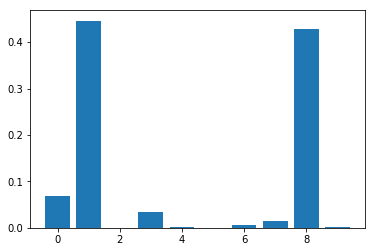

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(range(10), np.mean(attention, axis=0))
print(np.mean(attention, axis=0))

In [7]:
print('真实值',data['Y'][:10])
print('预测值:', dense_model.predict(data['X'][:10]))

真实值 [0.483 0.587 0.035 0.009 0.471 0.312 0.319 0.652 0.166 0.746]
预测值: [[0.50961006]
 [0.61784214]
 [0.08250739]
 [0.07742871]
 [0.4838765 ]
 [0.28396246]
 [0.28179035]
 [0.66745037]
 [0.1289852 ]
 [0.7194878 ]]


#### 注意机制的循环神经网络

网络的基本架构如下图, 这是一个多维注意机制架构图, 也就是每个时间步有不同的注意力分配向量。

- 输入, 张量的形状是: (BS, TS, I), 分别表示: Batch size, Time Steps, Demension
- 转置张量, 使得张量的形状变成:(BS, I, TS)
- 全连接层得到注意力权重, 得到的张量形状可以是 (BS, I, TS), 也可以是(BS, TS), 也可以是(BS, I), 这要看你想要让注意力如何分配
- 转置张量, 使得张量的维度恢复成(BS, TS, I), 或不需要转置的(BS, TS), (BS, I)
- 合并输入和注意力权重, 也就是element-wise的矩阵乘法, 或者row-wise的矩阵乘法

<img src="images/dense-attention.png" />

不过还有一种方式, 是所有时间步共享一个注意力分配向量, 如下图:

<img src="images/graph_single_attention.png" />

是时候实现一个注意机制的LSTM模型了, 在循环神经网络中, 输入的数据是二维的(TIME_STEP, DEMESION)。也就是说, 我们把每个数字编码成了one-hot向量, 具体做法参考创建数据的代码。而输出仍然是一个标量。

In [8]:
def build_lstm_model(only_time_step=True):
    inputs = Input(shape=(TIME_STEP, DEMESION))
    # 转置
    a = Permute((2,1))(inputs)
    # 现在a的形状是: (DEMENSION, TIME_STEP)
    # 目的就是为了得到每个时间步的权重
    a = Dense(TIME_STEP, activation='softmax')(a)
    if only_time_step:
        # 降低一个维度, 使得得到长度为TIME_STEP的向量
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        weight = a
        # 出重复这个向量得到一个矩阵便于下一步计算
        a = RepeatVector(DEMESION)(a)
        # 现在a的形状是(DEMESION, TIME_STEP)
    # 转置矩阵, 便于下一步计算乘法
    a_probs = Permute((2,1), name='attention_vec')(a)
    # 计算加权后的输入
    weighted_inputs = merge([inputs, a_probs], name='weighted_inputs', mode='mul')
    lstm_units = 64
    # 只需要返回最后的结果
    output = LSTM(lstm_units, return_sequences=False)(weighted_inputs)
    # 经过全连接层
    output = Dense(1, activation='sigmoid')(output)
    model = Model([inputs], output)
    weight_model = Model([inputs], weight)
    return model, weight_model

In [9]:
lstm_model, weight = build_lstm_model()
lstm_model.compile(optimizer='adam', loss='MSE')

d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\mysites\deeplearning.ai-master\.env\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [10]:
lstm_model.fit(data['X_one_hot'], data['Y'], epochs=10)

Epoch 1/10
300000/300000 [==============================] - 47s 155us/step - loss: 0.0146
Epoch 2/10
300000/300000 [==============================] - 46s 152us/step - loss: 1.3361e-04
Epoch 3/10
300000/300000 [==============================] - 46s 153us/step - loss: 1.8170e-05
Epoch 4/10
300000/300000 [==============================] - 47s 155us/step - loss: 1.0955e-05
Epoch 5/10
300000/300000 [==============================] - 47s 156us/step - loss: 7.9359e-06
Epoch 6/10
300000/300000 [==============================] - 48s 159us/step - loss: 6.3272e-06
Epoch 7/10
300000/300000 [==============================] - 46s 155us/step - loss: 5.5028e-06
Epoch 8/10
300000/300000 [==============================] - 45s 150us/step - loss: 4.9407e-06
Epoch 9/10
300000/300000 [==============================] - 45s 150us/step - loss: 4.3552e-06
Epoch 10/10
300000/300000 [==============================] - 46s 155us/step - loss: 3.9599e-06


In [11]:
weightV = weight.predict(data['X_one_hot'])

如果我们可视化一下权重, 可以看到不同时间步的权重, 这个效果并不吃惊, 循环神经网络的能力显然比单纯的感知机模型要好很多。

<BarContainer object of 10 artists>

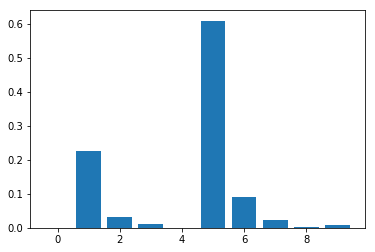

In [12]:
plt.bar(range(10), np.mean(weightV, axis=0))